In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import scipy.stats as st

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import r2_score, f1_score, recall_score, classification_report, confusion_matrix
from sklearn import tree

import lightgbm as lgb

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [2]:
df = pd.read_csv("data\secondary_data.csv", sep=";")

In [3]:
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [4]:
working_df = df.copy()
df_dropped = working_df.dropna(how="all")
dropped_list = ["stem-root","veil-type","veil-color","stem-surface","spore-print-color"]
df_dropped = df_dropped.drop(columns=dropped_list)

enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop="first")

In [5]:
df_dropped["gill-spacing"] = df_dropped["gill-spacing"].apply(lambda x: 0 if x=="c" else (1 if x=="d" else 2))
df_dropped["gill-color"] = df_dropped["gill-color"].apply(lambda x: 0 if x=="w" else (1 if x=="n" else (2 if x=="y" else 3)))
df_dropped["stem-color"] = df_dropped["stem-color"].apply(lambda x: 0 if x=="w" else (1 if x=="n" else (2 if x=="y" else 3)))
df_dropped["gill-attachment"] = df_dropped["gill-attachment"].apply(lambda x: 0 if x=="a" else 
                                                                    (1 if x=="d" else 
                                                                     (2 if x=="x" else 
                                                                      (3 if x=="p" else 
                                                                       (4 if x=="e" else 5)))))

df_dropped.drop(columns=["habitat", "season", "has-ring", "ring-type", "cap-surface"], inplace=True)

In [6]:
categorical_data = df_dropped.select_dtypes(include=['object']).columns.tolist()[1:]
hot_encoded = enc.fit_transform(df_dropped[categorical_data])
hot_encoded_df = pd.DataFrame(hot_encoded, columns=enc.get_feature_names_out(categorical_data))
df_encoded = pd.concat([df_dropped, hot_encoded_df], axis=1)
df_encoded = df_encoded.drop(categorical_data, axis=1)

df_encoded["class"] = pd.get_dummies(df_encoded["class"], dtype="int", drop_first=True, columns=["class"])

In [7]:
features = df_encoded.select_dtypes(include="number").drop(columns=["class"])
target = df_encoded["class"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.2, random_state=42)

norm = MinMaxScaler()
norm.fit(X_train)
X_train_norm = pd.DataFrame(norm.transform(X_train), columns=X_train.columns)
X_test_norm = pd.DataFrame(norm.transform(X_test), columns=X_test.columns)

knn = KNeighborsClassifier()
grid = {"n_neighbors":[x+1 for x in range(20)]}

gscv = GridSearchCV(knn, grid, cv=5)
gscv.fit(X_train_norm, y_train)
gscv.best_params_

{'n_neighbors': 1}

In [8]:
optimal_knn = KNeighborsClassifier(n_neighbors=1)
optimal_knn.fit(X_train_norm, y_train)
knn_pred = optimal_knn.predict(X_test_norm)

print(classification_report(knn_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5378
           1       1.00      1.00      1.00      6836

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214



In [9]:
recall_score(knn_pred, y_test)

0.9997074312463429

In [10]:
confusion_matrix(knn_pred, y_test)

array([[5372,    6],
       [   2, 6834]], dtype=int64)

**--**

In [11]:
from sklearn.tree import DecisionTreeClassifier

In [12]:
tree = DecisionTreeClassifier()
tree_grid = {"max_leaf_nodes":[5,10,15,20,None], "max_depth":[5,10,15,None], "random_state":[42]}

tree_gscv = GridSearchCV(tree, tree_grid, cv=5)
tree_gscv.fit(X_train_norm, y_train)
tree_gscv.best_params_

{'max_depth': None, 'max_leaf_nodes': None, 'random_state': 42}

In [13]:
optimal_tree = DecisionTreeClassifier(random_state=42)
optimal_tree.fit(X_train_norm, y_train)
tree_pred = optimal_tree.predict(X_test_norm)

print(classification_report(tree_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5365
           1       1.00      1.00      1.00      6849

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214



In [14]:
recall_score(tree_pred, y_test)

0.9953277850781136

In [15]:
confusion_matrix(tree_pred, y_test)

array([[5342,   23],
       [  32, 6817]], dtype=int64)

**--**

In [16]:
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=15,random_state=42)
model.fit(X_train_norm, y_train, eval_set=[(X_test_norm, y_test),(X_train_norm, y_train)],eval_metric='logloss')
lgbm_pred = model.predict(X_test_norm)

print(classification_report(lgbm_pred, y_test))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 27048, number of negative: 21807
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 48855, number of used features: 25
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553638 -> initscore=0.215382
[LightGBM] [Info] Start training from score 0.215382
[LightGBM] [Warning] Accuracy may be bad since you didn

In [17]:
recall_score(lgbm_pred, y_test)

0.9953195846131344

In [18]:
confusion_matrix(lgbm_pred, y_test)

array([[5342,   35],
       [  32, 6805]], dtype=int64)

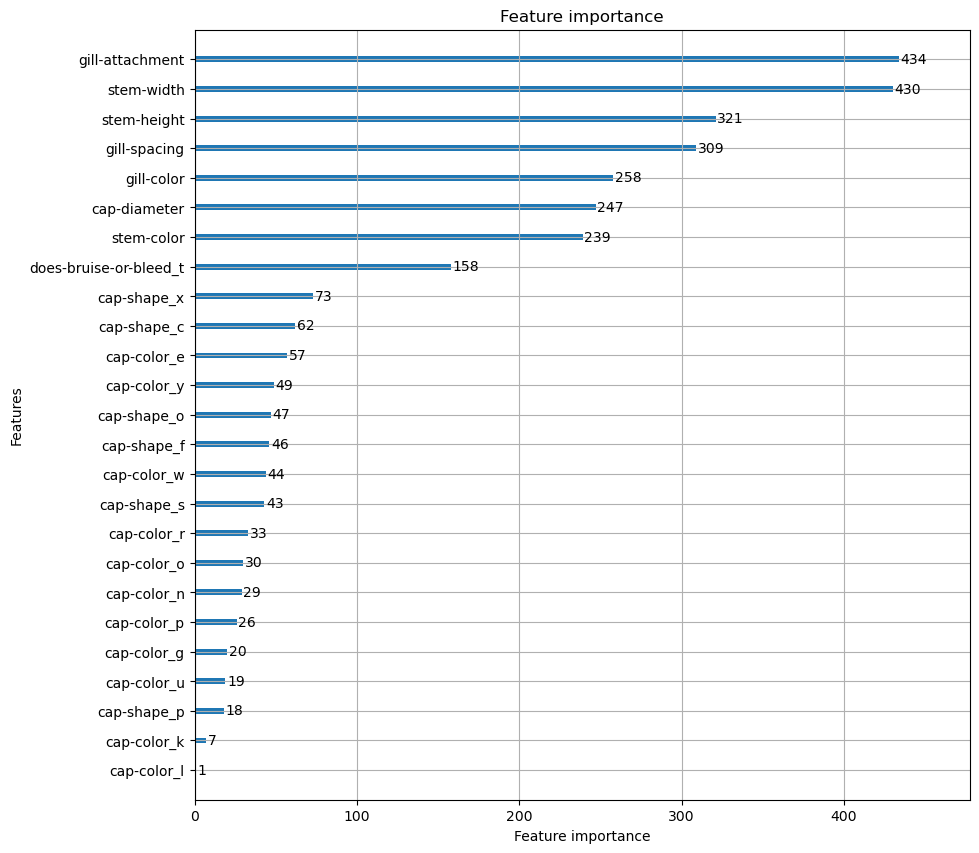

In [24]:
importance = lgb.plot_importance(model, figsize=(10,10))

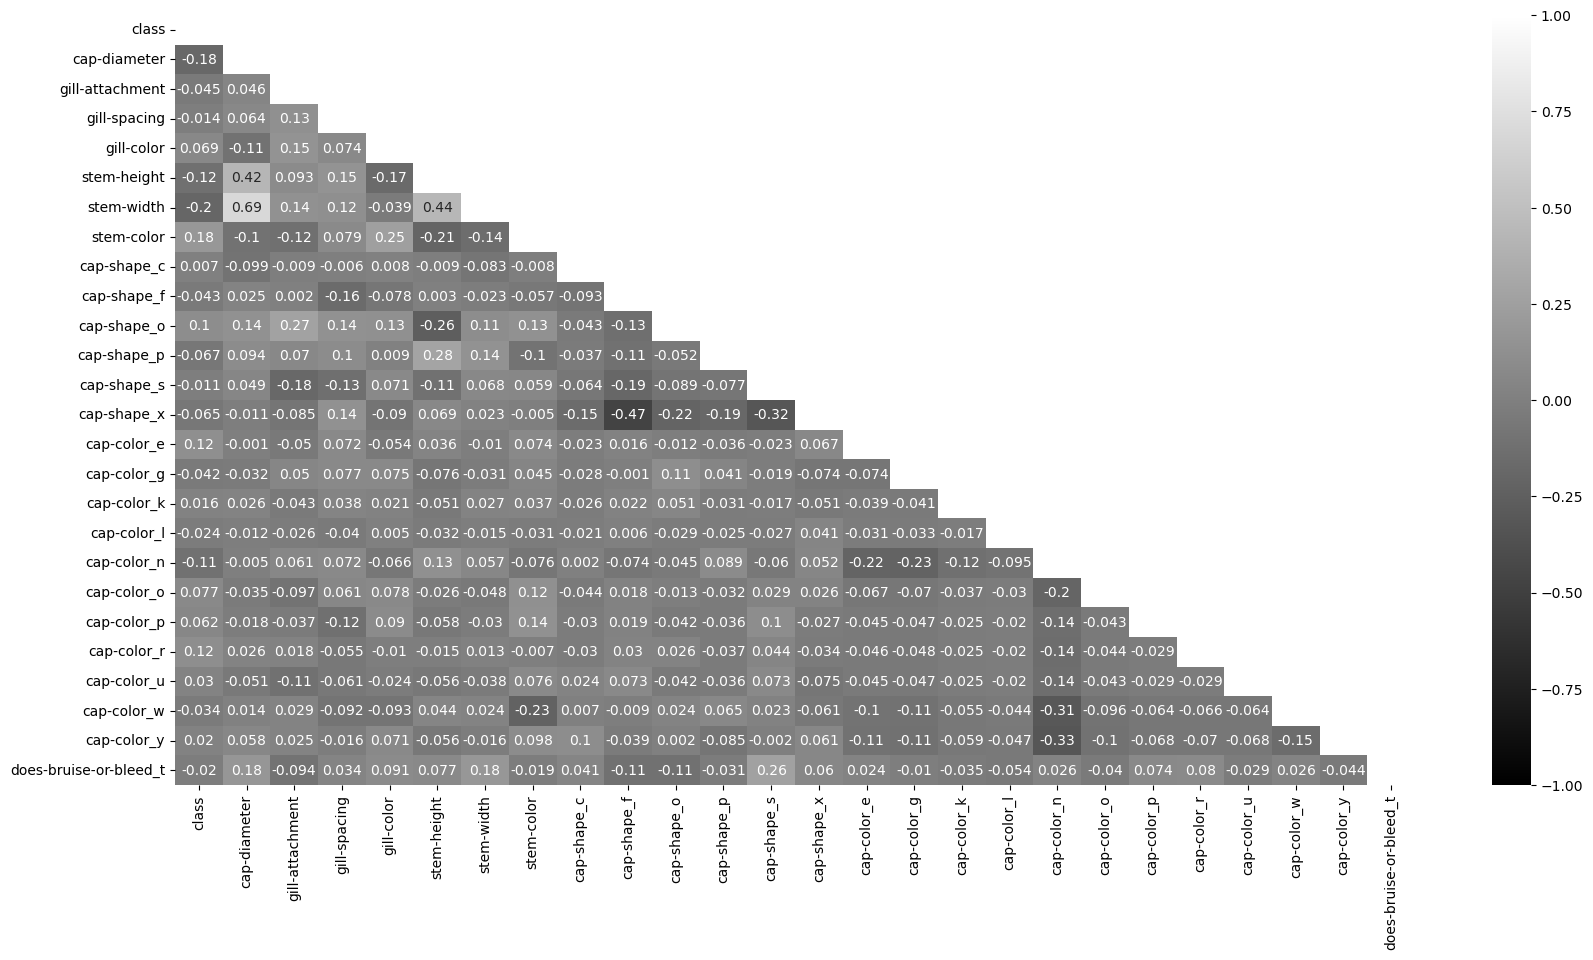

In [39]:
dropped_corr = df_encoded.corr().round(3)

mask = np.zeros_like(dropped_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20,10))
pplot_2 = sns.heatmap(dropped_corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap="gray")
pplot_2.get_figure().savefig("heatmap_new.png")